In [1]:
from typing import Optional
import os
import warnings
import random
import numpy as np
import torch
from torch.utils.data import Dataset, SequentialSampler, DataLoader
from torchvision import transforms
from decord import VideoReader, cpu
from datasets.random_erasing import RandomErasing
from datasets.video_transforms import (
    Compose, Resize, CenterCrop, Normalize,
    create_random_augment, random_short_side_scale_jitter, 
    random_crop, random_resized_crop_with_shift, random_resized_crop,
    horizontal_flip, random_short_side_scale_jitter, uniform_crop, 
)
from datasets.volume_transforms import ClipToTensor
import utils

class CondensedMovies(Dataset):
    def __init__(
        self, anno_path: str, data_path: str='', split: str=',', mode: str='train', clip_len: int=64,
        frame_sample_rate: int=2, aug_size: tuple=(720, 1280), target_size: tuple=(480, 854), n_seg: int=1, n_crop: int=1,
        test_n_seg: int=10, test_n_crop: int=3, min_duration=60, trimmed: int=180, time_stride: int=60
    ):
        self.anno_path = anno_path # meta data(duration.csv) path
        self.data_path = data_path # video path
        self.split = split # seperator in csv
        self.mode = mode
        self.clip_len = clip_len # kernel size in frame axis
        self.frame_sample_rate = frame_sample_rate
        self.aug_size = aug_size # Augementation size
        self.target_size = target_size # Video size
        self.n_seg = n_seg # 학습 시 비디오를 시간 축으로 몇 개의 segment로 나눌 것인지
        self.n_crop = n_crop # 각 segment에서 공간적으로 몇 개를 crop할 것인지
        self.test_n_seg = test_n_seg
        self.test_n_crop = test_n_crop
        self.trimmed = trimmed # 사용할 비디오 길이
        self.time_stride = time_stride
        self.aug = False # 데이터 증강 여부

        assert n_seg == 1

        # 학습 과정시
        if self.mode == 'train':
            self.aug = True # 데이터 증강 사용
            self.rand_erase = True # random erasing 사용
        
        import pandas as pd
        import ast

        df = pd.read_csv(self.anno_path, delimiter=self.split)
        df.iloc[:, 1] = df.iloc[:, 1].apply(ast.literal_eval)

        self.ori_ids = list(df.iloc[:, 0])
        self.ori_labels = list(df.iloc[:, 1])
        self.ori_durations = list(df.iloc[:, 2])

        self.ids = []
        self.labels = []
        self.starts = []
        self.ends = []

        # 비디오 길이 조절
        for idx, duration in enumerate(self.ori_durations):
            # 최소 min_duration 이상인 비디오만 사용
            if duration < min_duration:
                continue

            if duration < trimmed:
                self.ids.append(self.ori_ids[idx])
                self.labels.append(self.ori_labels[idx])
                self.starts.append(0)
                self.ends.append(duration)
            else:
                # 너무 긴 경우, 비디오를 잘라서 사용
                starts = [i for i in range(0, int(duration), time_stride)]

                # trimmed보다 긴 경우, time_stride 간격으로 비디오를 자름
                for start in starts:
                    end = start + trimmed
                    # 계산된 종료 시각이 실제 비디오 running time보다 길 경우
                    if end > duration:
                        if duration - start >= trimmed / 2: # 남은 비디오의 시간이 trimmed의 절반 이상인 경우
                            end = duration
                        else: # 그렇지 않으면 사용하지 않음
                            continue
                    
                    self.ids.append(self.ori_ids[idx])
                    self.labels.append(self.ori_labels[idx])
                    self.starts.append(start)
                    self.ends.append(end)
        
        # 개수가 많은 학습용 데이터만 제외해 전처리
        if mode == 'train':
            pass

        elif mode == 'validation':
            self.data_transform = Compose([
                Resize(self.aug_size, interpolation='bilinear'),
                CenterCrop(size=target_size),
                ClipToTensor(),
                Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]) # ImageNet
            ])
        elif mode == 'test':
            self.data_resize = Compose([
                Resize(self.target_size, interpolation='bilinear')
            ])
            self.data_transform = Compose([
                ClipToTensor(),
                Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]) # ImageNet
            ])

            self.test_seg = []
            self.test_ids = []
            self.test_labels = []
            self.test_starts = []
            self.test_ends = []
            # TTA(Test Time Arguementation)
            for ck in range(self.test_n_seg):
                for cp in range(self.test_n_crop):
                    for idx in range(len(self.labels)):
                        self.test_ids.append(self.ids[idx])
                        self.test_labels.append(self.labels[idx])
                        self.test_starts.append(self.starts[idx])
                        self.test_ends.append(self.ends[idx])
                        self.test_seg.append((ck, cp))
    
    def __getitem__(self, idx: int):
        if self.mode == 'train':
            # Video informations
            id = self.ids[idx]
            start = self.starts[idx]
            end = self.ends[idx]
            buffer = self.loadvideo_decord(id, start, end, chunk_nb=-1) # (T, H, W, C) ndarray
            if len(buffer) == 0:
                while len(buffer) == 0:
                    warnings.warn("video {} not correctly loaded during training".format(id))
                    index = np.random.randint(self.__len__())
                    id = self.ids[index]
                    start = self.starts[index]
                    end = self.ends[index]
                    buffer = self.loadvideo_decord(id, start, end, chunk_nb=-1)

            # 증강 여부
            frames = []
            labels = []
            indices = []
            # 데이터 증강
            for _ in range(2):
                new_frames = self._aug_frame(buffer) # (C, T, H, W)
                frames.append(new_frames)
                labels.append(self.labels[idx])
                indices.append(idx)
            
            return frames, torch.tensor(labels, dtype=torch.int32), indices, {}
        
        elif self.mode == 'validation':
            id = self.ids[idx]
            start = self.starts[idx]
            end = self.ends[idx]
            buffer = self.loadvideo_decord(id, start, end, chunk_nb=0)
            if len(buffer) == 0:
                while len(buffer) == 0:
                    warnings.warn("video {} not correctly loaded during training".format(id))
                    index = np.random.randint(self.__len__())
                    id = self.ids[index]
                    start = self.starts[index]
                    end = self.ends[index]
                    buffer = self.loadvideo_decord(id, start, end, chunk_nb=0)

            # 입력을 위한 transform
            buffer = self.data_transform(buffer) # Resize, CenterCrop, ClipToTensor, Normalize

            return buffer, torch.tensor(self.labels[idx], dtype=torch.int32), id
        
        elif self.mode == 'test':
            id = self.test_ids[idx]
            start = self.test_ids[idx]
            end = self.test_ids[idx]
            chunk_nb, split_nb = self.test_seg[idx]
            buffer = self.loadvideo_decord(id, start, end, chunk_nb=chunk_nb)
            
            while len(buffer) == 0:
                warnings.warn("video {}, temporal {}, spatial {} not found during testing".format(\
                    str(self.test_ids[idx]), chunk_nb, split_nb))
                idx = np.random.randint(self.__len__())
                sample = self.test_ids[idx]
                start = self.test_starts[idx]
                end = self.test_ends[idx]
                chunk_nb, split_nb = self.test_seg[idx]
                buffer = self.loadvideo_decord(sample, start, end, chunk_nb=chunk_nb)

            buffer = self.data_resize(buffer)
            if isinstance(buffer, list): # 비디오를 불러오지 못한 경우
                buffer = np.stack(buffer, 0)
            if self.test_n_crop == 1:
                spatial_step = int((max(buffer.shape[1], buffer.shape[2]) - self.target_size[0]) / 2) # 420 pixel
                spatial_start = spatial_step
            else:
                spatial_step = int((max(buffer.shape[1], buffer.shape[2]) - self.target_size[0]) / (self.test_n_crop - 1))
                spatial_start = spatial_step * split_nb 
            buffer = buffer[:, :, spatial_start:spatial_start + self.target_size[0], :] # Sampling
            buffer = self.data_transform(buffer) # ClipToTensor, Normalize

            return buffer, torch.tensor(self.test_labels[idx], dtype=torch.int32), self.test_ids[idx], chunk_nb, split_nb
        
    def _aug_frame(self, buffer):
        """
        데이터 증강

        buffer: Video tensor(T, H, W, C)
        """
        aug_transform = create_random_augment(
            input_size=self.aug_size,
            auto_augment="rand-m5-n2-mstd0.25-inc1",
            interpolation='bicubic'
        )
        # 변환을 위해 Tensor -> Image
        buffer = [transforms.ToPILImage()(frame) for frame in buffer] # (T, H, W, C)
        buffer = aug_transform(buffer)

        # 입력을 위해 Image -> Tensor
        buffer = [transforms.ToTensor()(img) for img in buffer] # (T, C, H, W)
        buffer = torch.stack(buffer) # (T, C, H, W)
        # 정규화를 위해 shape 변형
        buffer = buffer.permute(0, 2, 3, 1) # (T, H, W, C)
        buffer = tensor_normalize(buffer, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # spatial sampling을 위해 shape 변형
        buffer = buffer.permute(3, 0, 1, 2) # (C, T, H, W)

        scl, asp = (
            [0.5, 1.0],
            [0.75, 1.3333],
        )

        buffer = spatial_sampling(
            frames=buffer, target_height=self.target_size[0], target_width=self.target_size[1],
            random_horizontal_flip=True, scale=scl, aspect_ratio=asp
        )
        
        if self.rand_erase:
            random_erasing = RandomErasing(
                .25, mode='pixel', max_count=1,
                num_splits=1, device='cpu'
            )
            # random erasing을 위해 shape 변형
            buffer = buffer.permute(1, 0, 2, 3) # (T, C, H, W)
            buffer = random_erasing(buffer)
            # 모델의 입력값으로 사용하기 위해 shape 변형
            buffer = buffer.permute(1, 0, 2, 3) # (C, T, H, W)
        
        return buffer
    
    def _get_seq_frames(self, video_size: int, start: int, end: int, n_frames: int, clip_idx=-1):
        """
        비디오에서 프레임을 샘플링
        
        video_size: 비디오의 프레임 수
        start: 시작 프레임
        end: 마지막 프레임
        n_frames: 추출할 프레임 수
        clip_idx: mode 확인
        """
        # 시작 및 끝 시간 확인
        start = max(0, min(start, video_size - 1))
        end = max(start, min(end, video_size - 1))

        clipped_video_size = end - start + 1
        seg_size = max(0., (clipped_video_size - 1) / n_frames) # segment 크기
        seq = []

        # 비디오를 같은 시간 간격으로 잘라 segment 생성
        # 각 segment마다 랜덤으로 프레임을 샘플링
        if clip_idx == -1: # Train
            for i in range(n_frames):
                start_frame = int(np.round(seg_size * i)) + start # 각 segment의 첫 프레임
                end_frame = int(np.round(seg_size * (i + 1))) + start # 각 segment의 마지막 프레임
                idx = min(random.randint(start_frame, end_frame), end) # 각 segment에서 임의로 샘플링한 프레임
                seq.append(idx)
        else: # Eval
            n_seg = 1
            if self.mode == 'test':
                n_seg = self.test_n_seg
            duration = seg_size / (n_seg + 1)
            for i in range(n_frames):
                start_frame = int(np.round(seg_size * i)) + start
                idx = min(start_frame + int(duration * (clip_idx + 1)), end) # 샘플링할 프레임
                seq.append(idx)
        
        return seq



    def loadvideo_decord(self, id: str, start: int, end: int, chunk_nb=0):
        """
        비디오를 ndarray 형태로 로드
        
        id: Video id
        start: 시작 시간
        end: 끝 시간
        chunk_nb: -1이면 학습 모드, 0이면 검증 모드, 그 이외의 정수 값은 테스트 모드에서의 chunk idx
        """
        f_name = os.path.join(self.data_path, id)
        try:
            vr = VideoReader(f_name + '.mp4', ctx=cpu(0), num_threads=1)
            fps = vr.get_avg_fps()
            all_indices = self._get_seq_frames(len(vr), int(start * fps), int(end * fps), self.clip_len, clip_idx=chunk_nb)
            
            while len(all_indices) < self.clip_len:
                print(f"Some frame is not loaded in video({id})")
                all_indices = self._get_seq_frames(len(vr), int(start * fps), int(end * fps), self.clip_len, clip_idx=chunk_nb)

            vr.seek(0) # 시작 지점으로 읽는 지점 초기화

            return vr.get_batch(all_indices).asnumpy() # (T, H, W, C)의 tensor로 반환
        except:
            print(f"Video cannot be loaded by decord: {f_name}")
            return []
    
    def __len__(self):
        if self.mode != 'test':
            return len(self.ids)
        else:
            return len(self.test_ids)
        
def spatial_sampling(
        frames: torch.Tensor, target_height: int=720, target_width: int=1080,
        random_horizontal_flip: bool=True, scale: Optional[list]=None, aspect_ratio: Optional[list]=None
    ):
    """
    Random resized crop -> Horizontal flip
    """
    transform_func = random_resized_crop_with_shift
    frames = transform_func(
        images=frames, target_height=target_height, target_width=target_width, scale=scale, ratio=aspect_ratio
    )
    if random_horizontal_flip:
        frames, _ = horizontal_flip(.5, frames)
    
    return frames


def tensor_normalize(tensor: torch.Tensor, mean, std):
    tensor = tensor.float()
    if type(mean) == list:
        mean = torch.tensor(mean)
    if type(std) == list:
        std = torch.tensor(std)
    tensor = tensor - mean
    tensor = tensor / std
    return tensor

def build_dataset(is_train, is_test):

    mode = None
    anno_path = None

    if is_train == True:
        mode = 'train'
        anno_path = os.path.join('/nas/kks/data/condensed_movies/metadata', 'train_sample.csv')
    elif is_test == True:
        mode = 'test'
        anno_path = os.path.join('/nas/kks/data/condensed_movies/metadata', 'test.csv')
    else:
        mode = 'validation'
        anno_path = os.path.join('/nas/kks/data/condensed_movies/metadata', 'val.csv')
    
    dataset = CondensedMovies(
        anno_path=anno_path, data_path='/nas/kks/data/condensed_movies/videos', split=',', mode=mode, clip_len=64,
        frame_sample_rate=2, aug_size=(720, 1280), target_size=(480, 854), 
        n_seg=1, n_crop=1 if not is_train else 3, test_n_seg=4, test_n_crop=3,
        min_duration=60, trimmed=180, time_stride=60
    )
    all_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']
    cls_cnt_list = [3796, 2876, 661, 739, 6502, 2728, 109, 6389, 877, 1401, 149, 301, 1752, 422, 259, 1131, 2695, 1432, 7, 357, 2099, 265, 282]

    print(f"# of classes: {len(all_genres)}")

    return dataset, all_genres, cls_cnt_list

/home/kks/anaconda3/envs/video_mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset, _, _ = build_dataset(is_train=True, is_test=False)

dataset

# of classes: 23


In [6]:
import warnings
from tqdm import tqdm
from time import time
import multiprocessing as mp
import traceback

# 결과 저장을 위한 딕셔너리 생성
results = {}
for num_workers in tqdm(range(2, mp.cpu_count(), 2), desc="Testing num_workers"):
    train_loader = DataLoader(dataset, shuffle=True, num_workers=num_workers, batch_size=8
    
    , pin_memory=True)
    start = time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader):
            pass
    end = time()

    # 결과 저장
    results[num_workers] = end - start
    print(f"Finish with: {end - start:.2f} second, num_workers={num_workers}")

# 결과 출력 또는 저장
print(results)  # 딕셔너리 형태로 결과 출력

Testing num_workers:   0%|          | 0/35 [00:00<?, ?it/s][h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9b033c0] mmco: unref short failure
[h264 @ 0x9b033c0] mmco: unref short failure
[h264 @ 0x9b033c0] mmco: unref short failure
[h264 @ 0x9b033c0] mmco: unref short failure
[h264 @ 0x9b033c0] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9abd540] mmco: unref short failure
[h264 @ 0x9abd540] mmco: unref short failure
[h264 @ 0xa110f00] mmco: unref short failure
[h264 @ 0xa110f00] mmco: unref short failure
[h264 @ 0xa110f00] mmco: unref short failure
[h264 @ 0xa110f00] mmco: unref short failure
[h264 @ 0x9cbefc0] mmco: unref short failure
[h264 @ 0x9cbefc0] mmco: unref short failure
[h264 @ 0x9afd100] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short fail

Finish with: 1071.80 second, num_workers=2


[h264 @ 0x4c876d80] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0xa28afc0] mmco: unref short failure
[h264 @ 0xa28afc0] mmco: unref short failure
[h264 @ 0xa3dfa80] mmco: unref short failure
[h264 @ 0xa3dfa80] mmco: unref short failure
[h264 @ 0xa3dfa80] mmco: unref short failure
[h264 @ 0xa3dfa80] mmco: unref short failure
[h264 @ 0xa3dfa80] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9bfda40] mmco: unref short failure
[h264 @ 0x9bfda40] mmco: unref short failure
[h264 @ 0x9bfda40] mmco: unref short failure
[h264 @ 0

Finish with: 576.71 second, num_workers=4


[h264 @ 0xa299b80] mmco: unref short failure
[h264 @ 0xa299b80] mmco: unref short failure
[h264 @ 0x9c06d40] mmco: unref short failure
[h264 @ 0x9c06d40] mmco: unref short failure
[h264 @ 0x9c06d40] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b5c300] mmco: unref short failure
[h264 @ 0x9b5c300] mmco: unref short failure
[h264 @ 0x9b5c300] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x

Finish with: 433.34 second, num_workers=6


[h264 @ 0x9b07e40] mmco: unref short failure
[h264 @ 0x9b07e40] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9bb37c0] mmco: unref short failure
[h264 @ 0x9bb37c0] mmco: unref short failure
[h264 @ 0x9bb37c0] mmco: unref short failure
[h264 @ 0x9bb37c0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9cd2ec0] mmco: unref short failure
[h264 @ 0x

Finish with: 378.30 second, num_workers=8


[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x8a51dc0] mmco: unref short failure
[h264 @ 0x8a51dc0] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9a796c0] mmco: unref short failure
[h264 @ 0x9a796c0] mmco: unref short failure
[h264 @ 0x9a796c0] mmco: unref short failure
[h264 @ 0x9a796c0] mmco: unref short failure
[h264 @ 0xaaad740] mmco: unref short failure
[h264 @ 0x

Finish with: 300.79 second, num_workers=10


[h264 @ 0xa86e140] mmco: unref short failure
[h264 @ 0xa86e140] mmco: unref short failure
[h264 @ 0xa86e140] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9ae2c00] mmco: unref short failure
[h264 @ 0x9ae2c00] mmco: unref short failure
[h264 @ 0x9ae2c00] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9b08340] mmco: unref short failure
[h264 @ 0x9b08300] mmco: unref short failure
[h264 @ 0x9b08300] mmco: unref short failure
[h264 @ 0x

Finish with: 293.62 second, num_workers=12


[h264 @ 0x9ae29c0] mmco: unref short failure
[h264 @ 0x9ae29c0] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9cf50c0] mmco: unref short failure
[h264 @ 0x9cf50c0] mmco: unref short failure
[h264 @ 0x9cf50c0] mmco: unref short failure
[h264 @ 0x9cf50c0] mmco: unref short failure
[h264 @ 0x9cf50c0] mmco: unref short failure
[h264 @ 0x9cd2000] mmco: unref short failure
[h264 @ 0x9cd2000] mmco: unref short failure
[h264 @ 0x9cd2000] mmco: unref short failure
[h264 @ 0x9cd2000] mmco: unref short failure
[h264 @ 0x9b08140] mmco: unref short failure
[h264 @ 0x

Finish with: 296.24 second, num_workers=14


[h264 @ 0x9ad7640] mmco: unref short failure
[h264 @ 0x9ad7640] mmco: unref short failure
[h264 @ 0x9aeeb40] mmco: unref short failure
[h264 @ 0x9aeeb40] mmco: unref short failure
[h264 @ 0x9beaa80] mmco: unref short failure
[h264 @ 0x9beaa80] mmco: unref short failure
[h264 @ 0x9beaa80] mmco: unref short failure
[h264 @ 0x9beaa80] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9418fc0] mmco: unref short failure
[h264 @ 0x9418fc0] mmco: unref short failure
[h264 @ 0x9ae8580] mmco: unref short failure
[h264 @ 0x9ae8580] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x

Finish with: 421.52 second, num_workers=16


[h264 @ 0x9b5c340] mmco: unref short failure
[h264 @ 0x9b5c340] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9419c80] mmco: unref short failure
[h264 @ 0x9419c80] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9fd8280] mmco: unref short failure
[h264 @ 0x9fd8280] mmco: unref short failure
[h264 @ 0xa826440] mmco: unref short failure
[h264 @ 0xa826440] mmco: unref short failure
[h264 @ 0xa826440] mmco: unref short failure
[h264 @ 0x9b5c6c0] mmco: unref short failure
[h264 @ 0x9b5c6c0] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9fd98c0] mmco: unref short failure
[h264 @ 0x

Finish with: 611.66 second, num_workers=18


[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9eb4980] mmco: unref short failure
[h264 @ 0x9eb4980] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9f79b40] mmco: unref short failure
[h264 @ 0x9f79b40] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0xa512f40] mmco: unref short failure
[h264 @ 0xa512f40] mmco: unref short failure
[h264 @ 0xa512f40] mmco: unref short failure
[h264 @ 0x

Finish with: 628.22 second, num_workers=20


[h264 @ 0x9ae4880] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9ae79c0] mmco: unref short failure
[h264 @ 0x9ae79c0] mmco: unref short failure
[h264 @ 0x9ae79c0] mmco: unref short failure
[h264 @ 0x9d08700] mmco: unref short failure
[h264 @ 0x9d08700] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9aeaa40] mmco: unref short failure
[h264 @ 0x9aeaa40] mmco: unref short failure
[h264 @ 0x9aeaa40] mmco: unref short failure
[h264 @ 0x9ae8e80] mmco: unref short failure
[h264 @ 0x9ae8e80] mmco: unref short failure
[h264 @ 0x

Finish with: 790.21 second, num_workers=22


[h264 @ 0xa021680] mmco: unref short failure
[h264 @ 0xa021680] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x1e3904c0] mmco: unref short failure
[h264 @ 0x1e3904c0] mmco: unref short failure
[h264 @ 0x1e3904c0] mmco: unref short failure
[h264 @ 0x9acbe00] mmco: unref short failure
[h264 @ 0x9acbe00] mmco: unref short failure
[h264 @ 0x9acbe00] mmco: unref short failure
[h264 @ 0x9ae5440] mmco: unref short failure
[h264 @ 0x9ae5440] mmco: unref short failure
[h264 @ 0x9ae5440] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @

Finish with: 723.91 second, num_workers=24


[h264 @ 0x9af0f80] mmco: unref short failure
[h264 @ 0x9af0f80] mmco: unref short failure
[h264 @ 0x9af0f80] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0xa0b2d80] mmco: unref short failure
[h264 @ 0xa0b2d80] mmco: unref short failure
[h264 @ 0xa0b2d80] mmco: unref short failure
[h264 @ 0xa0b2d80] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0xa8b7780] mmco: unref short failure
[h264 @ 0xa8b7780] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9b32600] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9901ec0] mmco: unref short failure
[h264 @ 0x9ae6140] mmco: unref short failure
[h264 @ 0x9ae6140] mmco: unref short failure
[h264 @ 0x

Finish with: 712.75 second, num_workers=26


[h264 @ 0x9af0f80] mmco: unref short failure
[h264 @ 0x9af0f80] mmco: unref short failure
[h264 @ 0xa41e840] mmco: unref short failure
[h264 @ 0xa41e840] mmco: unref short failure
[h264 @ 0xa41e840] mmco: unref short failure
[h264 @ 0x9c7a680] mmco: unref short failure
[h264 @ 0x9c7a680] mmco: unref short failure
[h264 @ 0x9c7a680] mmco: unref short failure
[h264 @ 0x9c7a680] mmco: unref short failure
[h264 @ 0x9ae5d80] mmco: unref short failure
[h264 @ 0x9ae5d80] mmco: unref short failure
[h264 @ 0x9ae79c0] mmco: unref short failure
[h264 @ 0x9ae79c0] mmco: unref short failure
[h264 @ 0x9ae79c0] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9bfe8c0] mmco: unref short failure
[h264 @ 0x9bfe8c0] mmco: unref short failure
[h264 @ 0x9bfe8c0] mmco: unref short failure
[h264 @ 0x9bfe8c0] mmco: unref short failure
[h264 @ 0x9bfe8c0] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x

Finish with: 664.34 second, num_workers=28


[h264 @ 0x9ac7b40] mmco: unref short failure
[h264 @ 0x9ac7b40] mmco: unref short failure
[h264 @ 0x9ac7b40] mmco: unref short failure
[h264 @ 0x9ad67c0] mmco: unref short failure
[h264 @ 0x9ad67c0] mmco: unref short failure
[h264 @ 0xa1af3c0] mmco: unref short failure
[h264 @ 0xa868800] mmco: unref short failure
[h264 @ 0xa868800] mmco: unref short failure
[h264 @ 0xa1af3c0] mmco: unref short failure
[h264 @ 0x9b5d240] mmco: unref short failure
[h264 @ 0x9b5d240] mmco: unref short failure
[h264 @ 0x9b5d240] mmco: unref short failure
[h264 @ 0x9b5d240] mmco: unref short failure
[h264 @ 0xa868800] mmco: unref short failure
[h264 @ 0xa868800] mmco: unref short failure
[h264 @ 0xa868800] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9ad77c0] mmco: unref short failure
[h264 @ 0x9ad77c0] mmco: unref short failure
[h264 @ 0x9ad77c0] mmco: unref short failure
[h264 @ 0x9ad77c0] mmco: unref short failure
[h264 @ 0x

Finish with: 746.61 second, num_workers=30


[h264 @ 0x9c605c0] mmco: unref short failure
[h264 @ 0x9c605c0] mmco: unref short failure
[h264 @ 0xa5a7e40] mmco: unref short failure
[h264 @ 0xa5a7e40] mmco: unref short failure
[h264 @ 0xa5a7e40] mmco: unref short failure
[h264 @ 0xa5a7e40] mmco: unref short failure
[h264 @ 0xa5a7e40] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9ad2680] mmco: unref short failure
[h264 @ 0x

Finish with: 714.72 second, num_workers=32


[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9adb080] mmco: unref short failure
[h264 @ 0x9aea0c0] mmco: unref short failure
[h264 @ 0x9aea0c0] mmco: unref short failure
[h264 @ 0x9af1d80] mmco: unref short failure
[h264 @ 0x9af1d80] mmco: unref short failure
[h264 @ 0x9af1d80] mmco: unref short failure
[h264 @ 0x9af1d80] mmco: unref short failure
[h264 @ 0x9eaea80] mmco: unref short failure
[h264 @ 0x9eaea80] mmco: unref short failure
[h264 @ 0x9cd5f40] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x9afa980] mmco: unref short failure
[h264 @ 0x9af1d80] mmco: unref short failure
[h264 @ 0x9af1d80] mmco: unref short failure
[h264 @ 0x9afa980] mmco: unref short failure
[h264 @ 0x9afa980] mmco: unref short failure
[h264 @ 0x9afbfc0] mmco: unref short failure
[h264 @ 0x9afbfc0] mmco: unref short failure
[h264 @ 0x9afbfc0] mmco: unref short failure
[h264 @ 0x

Finish with: 783.05 second, num_workers=34


[h264 @ 0x9ad77c0] mmco: unref short failure
[h264 @ 0x9ad77c0] mmco: unref short failure
[h264 @ 0x9afdd00] mmco: unref short failure
[h264 @ 0x9afdd00] mmco: unref short failure
[h264 @ 0x9afdd00] mmco: unref short failure
[h264 @ 0xa572340] mmco: unref short failure
[h264 @ 0xa572340] mmco: unref short failure
[h264 @ 0xa572340] mmco: unref short failure
[h264 @ 0xa572340] mmco: unref short failure
[h264 @ 0xa572340] mmco: unref short failure
[h264 @ 0x9ac7b40] mmco: unref short failure
[h264 @ 0x9ac7b40] mmco: unref short failure
[h264 @ 0x9b5d240] mmco: unref short failure
[h264 @ 0x9b5d240] mmco: unref short failure
[h264 @ 0x986e240] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9adcd80] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9ad9400] mmco: unref short failure
[h264 @ 0x9b596c0] mmco: unref short failure
[h264 @ 0x

KeyboardInterrupt: 

In [5]:
results

{2: 1824.2930824756622, 4: 1407.4671301841736, 6: 1825.0889151096344}

In [73]:
from videomamba import VisionMamba

def videomamba_middle(pretrained=False, **kwargs):
    model = VisionMamba(
        embed_dim=576,
        depth=32,
        residual_in_fp32=True,
        # rms_norm=True,
        # fused_add_norm=True,
        rms_norm=False,
        fused_add_norm=False,
        **kwargs
    )
    
    return model

model = videomamba_middle(
    pretrained=False, height=480, width=854, n_classes=2, fc_drop_rate=.3, drop_path_rate=.3, kernel_size=1,
    n_frames=2, use_checkpoint=False, checkpoint_num=32
)

model

Use chcekpoint: False
Checkpoint number: 32


VisionMamba(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(3, 576, kernel_size=(1, 16, 16), stride=(1, 16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (head): Linear(in_features=576, out_features=2, bias=True)
  (head_drop): Dropout(p=0.3, inplace=False)
  (drop_path): DropPath()
  (layers): ModuleList(
    (0): Block(
      (mixer): Mamba(
        (in_proj): Linear(in_features=576, out_features=2304, bias=False)
        (conv1d): Conv1d(1152, 1152, kernel_size=(4,), stride=(1,), padding=(3,), groups=1152)
        (act): SiLU()
        (x_proj): Linear(in_features=1152, out_features=68, bias=False)
        (dt_proj): Linear(in_features=36, out_features=1152, bias=True)
        (conv1d_b): Conv1d(1152, 1152, kernel_size=(4,), stride=(1,), padding=(3,), groups=1152)
        (x_proj_b): Linear(in_features=1152, out_features=68, bias=False)
        (dt_proj_b): Linear(in_features=36, out_features=1152, bias=True)
        (out_proj): Linear(in_features=1152, out_features=576, b

In [74]:
for name, val in model.named_parameters():
    print(name)

cls_token
pos_embed
temporal_pos_embedding
patch_embed.proj.weight
patch_embed.proj.bias
head.weight
head.bias
layers.0.mixer.A_log
layers.0.mixer.D
layers.0.mixer.A_b_log
layers.0.mixer.D_b
layers.0.mixer.in_proj.weight
layers.0.mixer.conv1d.weight
layers.0.mixer.conv1d.bias
layers.0.mixer.x_proj.weight
layers.0.mixer.dt_proj.weight
layers.0.mixer.dt_proj.bias
layers.0.mixer.conv1d_b.weight
layers.0.mixer.conv1d_b.bias
layers.0.mixer.x_proj_b.weight
layers.0.mixer.dt_proj_b.weight
layers.0.mixer.dt_proj_b.bias
layers.0.mixer.out_proj.weight
layers.0.norm.weight
layers.0.norm.bias
layers.1.mixer.A_log
layers.1.mixer.D
layers.1.mixer.A_b_log
layers.1.mixer.D_b
layers.1.mixer.in_proj.weight
layers.1.mixer.conv1d.weight
layers.1.mixer.conv1d.bias
layers.1.mixer.x_proj.weight
layers.1.mixer.dt_proj.weight
layers.1.mixer.dt_proj.bias
layers.1.mixer.conv1d_b.weight
layers.1.mixer.conv1d_b.bias
layers.1.mixer.x_proj_b.weight
layers.1.mixer.dt_proj_b.weight
layers.1.mixer.dt_proj_b.bias
layers

In [75]:
def get_parameter_groups(
        model, weight_decay=1e-5, skip_list=(), get_num_layer=None, 
        get_layer_scale=None,
    ):
    """
    paramters를 그룹으로 나누어 각 그룹별로 다른 weight decay와 lr을 적용하는 dictionary 생성 및 반환 
    """
    parameter_group_names = {}
    parameter_group_vars = {}

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        # bias이거나 decay를 적용하지 않는 파라미터인 경우
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list: 
            group_name = "no_decay"
            this_weight_decay = 0.
        else:
            group_name = "decay"
            this_weight_decay = weight_decay
        if get_num_layer is not None:
            layer_id = get_num_layer(name) # layer index
            group_name = "layer_%d_%s" % (layer_id, group_name)
        else:
            layer_id = None

        if group_name not in parameter_group_names:
            if get_layer_scale is not None:
                scale = get_layer_scale(layer_id)
            else:
                # 아닐 경우는 1로 사용
                scale = 1.
            
            parameter_group_names[group_name] = {
                "weight_decay": this_weight_decay,
                "params": [],
                "lr_scale": scale
            }
            parameter_group_vars[group_name] = {
                "weight_decay": this_weight_decay,
                "params": [],
                "lr_scale": scale
            }

        parameter_group_names[group_name]["params"].append(name)
        parameter_group_vars[group_name]["params"].append(param)
    return list(parameter_group_vars.values()) # 각 파라미터의 감쇠율을 list로 wrapping된 dictionary 형태로 반환

def get_num_layer_for_videomamba(var_name, num_max_layer):
    if var_name in ("cls_token", "pos_embed", "temporal_pos_embedding"):
        return 0
    elif var_name.startswith("patch_embed") or var_name.startswith("head") or var_name.startswith("norm_f"):
        return 0
    elif var_name.startswith("layers"): # for VideoMamba
        layer_id = int(var_name.split('.')[1])
        if 'mixer' in var_name:
            return layer_id + 1
        else:
            return 0
    else:
        return num_max_layer

class LayerDecayValueAssigner(object):
    def __init__(self, values):
        self.values = values

    def get_scale(self, layer_id):
        return self.values[layer_id]

    def get_layer_id(self, var_name):
        return get_num_layer_for_videomamba(var_name, len(self.values))

import math

def wd_scheduler(base_value, final_value, start_epoch, epochs, warmup_epochs=0, start_warmup_wd=0.):
    """
    base_value: 최대값
    final_value: 최종값

    warmup과 관련된 parameter에 값이 전달 되면 lr, 아니면 wd
    """
    warmup_schedule = np.array([])
    if start_warmup_wd != 0:
        print("Set warmup steps = %d" % warmup_epochs)
    else:
        pass
    if warmup_epochs > 0:
        # warmup의 처음 lr에서 base_value까지를 선형으로 설정
        warmup_schedule = np.linspace(start_warmup_wd, base_value, warmup_epochs)

    # warmup을 제외한 본 학습의 step 수
    iters = np.arange(epochs - warmup_epochs)

    # 본 학습의 schedule
    # 진폭: 0.5 * (base_value - final_value), 주기: 2 * pi * n_iters
    schedule = np.array(
        [final_value + 0.5 * (base_value - final_value) * (1 + math.cos(math.pi * i / (len(iters)))) for i in iters]
    )

    # 전체 학습의 schedule
    schedule = np.concatenate((warmup_schedule, schedule))

    assert len(schedule) == epochs # 유효성 확인
    return np.asarray(schedule[start_epoch:epochs + 1])

class CosineAnnealingWarmUpRestarts():
    def __init__(self,base_lr, max_lr, T_0, T_mul, T_up, gamma, n_iters_per_epoch, last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mul < 1 or not isinstance(T_mul, int):
            raise ValueError("Expected integer T_mul >= 1, but got {}".format(T_mul))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        
        self.T_0 = T_0
        self.T_mul = T_mul
        self.base_max_lr = max_lr
        self.max_lr = max_lr
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        self.base_lr = base_lr
        self.n_iter_per_epoch = n_iters_per_epoch
        self.last_epoch = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__()
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lr
        elif self.T_cur < self.T_up:
            return (self.max_lr - self.base_lr) * self.T_cur / self.T_up + self.base_lr 
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = self.T_0 * self.T_mul ** self.cycle
        else:
            if epoch >= self.T_0:
                if self.T_mul == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mul - 1) + 1), self.T_mul))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mul ** n - 1) / (self.T_mul - 1)
                    self.T_i = self.T_0 * self.T_mul ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
    
    def get_lrs(self, last_epoch, epochs):
        scheduler = []
        for _ in range(epochs):
            self.step()
            scheduler.append(self.get_lr())
        
        return scheduler[(last_epoch + 1) * self.n_iter_per_epoch:(epochs + 1) * self.n_iter_per_epoch]


assigner = LayerDecayValueAssigner(list(.9 ** i for i in range(32 + 1)))
param_groups = get_parameter_groups(model, 0.1, model.no_weight_decay(), assigner.get_layer_id, assigner.get_scale)

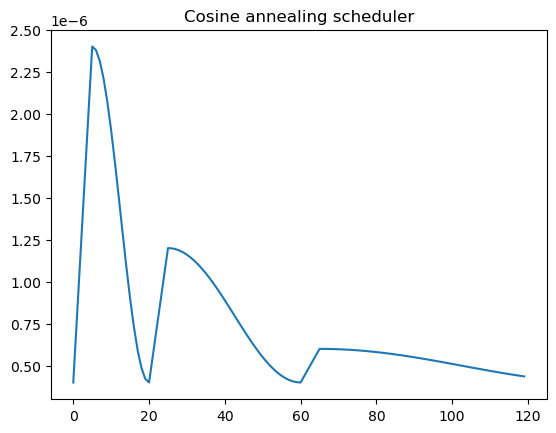

In [76]:
batch_size = 4
update_freq = 64
n_samples = 2
n_frames = 1
lr = 6e-7 * batch_size * update_freq * 2 * n_samples / 256
min_lr = 1e-8 * batch_size * update_freq * 2 * n_samples / 256
warmup_lr = 1e-7 * batch_size * update_freq * 2 * n_samples / 256


lr_scheduler = CosineAnnealingWarmUpRestarts(warmup_lr, lr, 20, 2, 5, 0.5, 30, -1)
lr_schedule_values = lr_scheduler.get_lrs(-1, 120)

import matplotlib.pyplot as plt

plt.plot(range(len(lr_schedule_values)), lr_schedule_values)
plt.title("Cosine annealing scheduler")
plt.show()

In [77]:
lr_schedule_values

[4e-07,
 8e-07,
 1.2e-06,
 1.6e-06,
 2e-06,
 2.4e-06,
 2.3781476007338054e-06,
 2.3135454576426007e-06,
 2.2090169943749476e-06,
 2.069130606358858e-06,
 1.9e-06,
 1.7090169943749473e-06,
 1.5045284632676535e-06,
 1.2954715367323466e-06,
 1.0909830056250526e-06,
 9.000000000000002e-07,
 7.30869393641142e-07,
 5.909830056250526e-07,
 4.86454542357399e-07,
 4.218523992661943e-07,
 4e-07,
 5.599999999999999e-07,
 7.2e-07,
 8.799999999999999e-07,
 1.04e-06,
 1.2e-06,
 1.1983897175980956e-06,
 1.1935718354394518e-06,
 1.1855851442783412e-06,
 1.1744939482558948e-06,
 1.1603875471609676e-06,
 1.1433795174407465e-06,
 1.123606797749979e-06,
 1.1012285864014444e-06,
 1.0764250595947458e-06,
 1.0493959207434934e-06,
 1.020358792580841e-06,
 9.895474649891994e-07,
 9.572100126615694e-07,
 9.23606797749979e-07,
 8.890083735825257e-07,
 8.536933063270621e-07,
 8.17945932140206e-07,
 7.820540678597941e-07,
 7.463066936729378e-07,
 7.109916264174742e-07,
 6.76393202250021e-07,
 6.427899873384306e-07

In [78]:
max(lr_schedule_values), len(lr_schedule_values)

(2.4e-06, 120)

Set warmup steps = 5


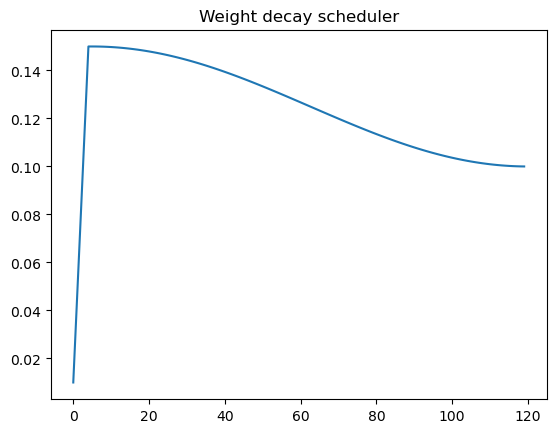

In [79]:
wd_schedule_values = wd_scheduler(0.15, 0.1, 0, 120, 5, 0.01)
plt.plot(range(len(wd_schedule_values)), wd_schedule_values)
plt.title("Weight decay scheduler")
plt.show()

In [52]:
import torch

t = torch.rand(768, 3, 16, 16)
spatial_dims = (80, 80)  # 모든 공간 차원의 크기를 가져옴

t = torch.nn.functional.interpolate(
    t, size=spatial_dims, mode='bilinear', align_corners=False
)

In [53]:
time_dim

196

In [54]:
t.shape

torch.Size([768, 3, 80, 80])

In [60]:
from videomamba import videomamba_base

pretrained_model = videomamba_base(
    pretrained=True, height=480, width=854, n_classes=2, fc_drop_rate=.3, drop_path_rate=.3, kernel_size=1,
    n_frames=2, use_checkpoint=False, checkpoint_num=32
)
model = videomamba_base(
    pretrained=False, height=480, width=854, n_classes=2, fc_drop_rate=.3, drop_path_rate=.3, kernel_size=1,
    n_frames=2, use_checkpoint=False, checkpoint_num=32
)

Use chcekpoint: False
Checkpoint number: 32
Load pretrained params

Interpolating pos_embed, torch.Size([1, 197, 768]) => torch.Size([1, 1591, 768])


Interpolating patch_embed.proj.weight, torch.Size([768, 3, 16, 16]) => torch.Size([768, 3, 1, 16, 16])

Init center: True
Inflate: patch_embed.proj.weight, torch.Size([768, 3, 1, 16, 16]) => torch.Size([768, 3, 1, 16, 16])
Ignore: head.weight
Ignore: head.bias
_IncompatibleKeys(missing_keys=['temporal_pos_embedding', 'head.weight', 'head.bias'], unexpected_keys=['distill_head.0.weight', 'distill_head.1.weight', 'distill_head.1.bias'])
Use chcekpoint: False
Checkpoint number: 32


In [62]:
for name, val in pretrained_model.named_parameters():
    print(f"{name:<40} {val.shape}")

cls_token                                torch.Size([1, 1, 768])
pos_embed                                torch.Size([1, 1591, 768])
temporal_pos_embedding                   torch.Size([1, 2, 768])
patch_embed.proj.weight                  torch.Size([768, 3, 1, 16, 16])
patch_embed.proj.bias                    torch.Size([768])
head.weight                              torch.Size([2, 768])
head.bias                                torch.Size([2])
layers.0.mixer.A_log                     torch.Size([1536, 16])
layers.0.mixer.D                         torch.Size([1536])
layers.0.mixer.A_b_log                   torch.Size([1536, 16])
layers.0.mixer.D_b                       torch.Size([1536])
layers.0.mixer.in_proj.weight            torch.Size([3072, 768])
layers.0.mixer.conv1d.weight             torch.Size([1536, 1, 4])
layers.0.mixer.conv1d.bias               torch.Size([1536])
layers.0.mixer.x_proj.weight             torch.Size([80, 1536])
layers.0.mixer.dt_proj.weight            torch.S

In [63]:
for name, val in model.named_parameters():
    print(f"{name:<40} {val.shape}")

cls_token                                torch.Size([1, 1, 768])
pos_embed                                torch.Size([1, 1591, 768])
temporal_pos_embedding                   torch.Size([1, 2, 768])
patch_embed.proj.weight                  torch.Size([768, 3, 1, 16, 16])
patch_embed.proj.bias                    torch.Size([768])
head.weight                              torch.Size([2, 768])
head.bias                                torch.Size([2])
layers.0.mixer.A_log                     torch.Size([1536, 16])
layers.0.mixer.D                         torch.Size([1536])
layers.0.mixer.A_b_log                   torch.Size([1536, 16])
layers.0.mixer.D_b                       torch.Size([1536])
layers.0.mixer.in_proj.weight            torch.Size([3072, 768])
layers.0.mixer.conv1d.weight             torch.Size([1536, 1, 4])
layers.0.mixer.conv1d.bias               torch.Size([1536])
layers.0.mixer.x_proj.weight             torch.Size([80, 1536])
layers.0.mixer.dt_proj.weight            torch.S

In [7]:
from model import Model

model = Model(n_frames=2, tubelet_size=1).cuda()

Use chcekpoint: True
Checkpoint number: 24


/home/kks/anaconda3/envs/video_mamba/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
for name, val in model.named_parameters():
    splited = splited
    if splited[1] in ("cls_token", "pos_embed", "temporal_pos_embedding"):
        print(0) 
    elif splited[1] == ("patch_embed") or splited[1] == ("embedding") or splited[1] == ("head") or splited[1] == ("norm_f"):
        print(0) 
    elif name.startswith("layers"): # for model
        layer_id = int(splited[2])
        if 'mixer' in name:
            print(layer_id + 1) 
        else:
            print(0) 
    else:
        print(name, -1) 

video_encoder.cls_token -1
video_encoder.pos_embed -1
video_encoder.temporal_pos_embedding -1
0
0
video_encoder.layers.0.mixer.A_log -1
video_encoder.layers.0.mixer.D -1
video_encoder.layers.0.mixer.A_b_log -1
video_encoder.layers.0.mixer.D_b -1
video_encoder.layers.0.mixer.in_proj.weight -1
video_encoder.layers.0.mixer.conv1d.weight -1
video_encoder.layers.0.mixer.conv1d.bias -1
video_encoder.layers.0.mixer.x_proj.weight -1
video_encoder.layers.0.mixer.dt_proj.weight -1
video_encoder.layers.0.mixer.dt_proj.bias -1
video_encoder.layers.0.mixer.conv1d_b.weight -1
video_encoder.layers.0.mixer.conv1d_b.bias -1
video_encoder.layers.0.mixer.x_proj_b.weight -1
video_encoder.layers.0.mixer.dt_proj_b.weight -1
video_encoder.layers.0.mixer.dt_proj_b.bias -1
video_encoder.layers.0.mixer.out_proj.weight -1
video_encoder.layers.0.norm.weight -1
video_encoder.layers.1.mixer.A_log -1
video_encoder.layers.1.mixer.D -1
video_encoder.layers.1.mixer.A_b_log -1
video_encoder.layers.1.mixer.D_b -1
video_e